In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnohakim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


## Prepare Stopwords

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['http','https','www','com','@','...','…', 'var', 'ref', 'document', 
             'referrer', 'var', 'bbpath', 'href', 'archive', 'function', 'beige',
            'book', 'federal', 'reserve', 'summary', 'indexof', 'backtoresults',
            'history', 'go', 'else', 'window', 'location', 'back', 'search',
            'this', 'report', 'prepared', 'federal', 'reserve', 'bank', 'summarizes',
            'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august',
            'september', 'october', 'november', 'december', 'atlanta', 'boston', 'chicago',
            'cleveland', 'dallas', 'kansas', 'minneapolis', 'york', 'philadelphia', 
             'richmond', 'san', 'francisco', 'st', 'louis', 'officials', 'comments', 
             'views', 'commentary', 'national', 'based', 'information', 'collected',
             'received', 'contacts', 'outside', 'system', 'page', 'url', 'link', 
                   'district', 'districts', 'activity'])



In [4]:
df = pd.read_csv('./data/beige_book_district.csv')
df.head()

,district_report,date,district
0,\n\r\n var ref = document.referrer;\r\n ...,2019-04,at
1,\n\r\n var ref = document.referrer;\r\n ...,2019-03,at
2,\n\r\n var ref = document.referrer;\r\n ...,2019-01,at
3,\n\r\n var ref = document.referrer;\r\n ...,2018-12,at
4,\n\r\n var ref = document.referrer;\r\n ...,2018-10,at


## Remove Special Characters

In [5]:
# Convert to list
data = df['district_report'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

[' var ref = document.referrer; var bBPath = beige-book-archive; function '
 'backToResults() { if (ref.indexOf(bBPath) > -1) { history.go(-1); } else { '
 'window.location.href = "./"; } } ‹ Back to Archive Search Beige Book Report: '
 'Atlanta April 17, 2019 Summary of Economic Activity Sixth District business '
 'contacts indicated that economic conditions improved, albeit at a modest '
 'pace, from the previous report. The majority of contacts expect growth to '
 'continue at relatively the same pace over the next few months. While the '
 'labor market remained tight, wage growth remained subdued for most jobs, '
 'with the exception of in-demand or hard-to-fill positions. Most firms noted '
 'that nonlabor input cost pressures were muted, though some observed '
 'increases related to tariffs, freight, and construction costs. Overall, '
 'retail sales grew slightly and automotive dealers remarked that demand for '
 'vehicles weakened since the previous report. Hospitality contacts 

## Tokenize words and Clean-up text

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['var', 'ref', 'document', 'referrer', 'var', 'bbpath', 'beige', 'book', 'archive', 'function', 'backtoresults', 'if', 'ref', 'indexof', 'bbpath', 'history', 'go', 'else', 'window', 'location', 'href', 'back', 'to', 'archive', 'search', 'beige', 'book', 'report', 'atlanta', 'april', 'summary', 'of', 'economic', 'activity', 'sixth', 'district', 'business', 'contacts', 'indicated', 'that', 'economic', 'conditions', 'improved', 'albeit', 'at', 'modest', 'pace', 'from', 'the', 'previous', 'report', 'the', 'majority', 'of', 'contacts', 'expect', 'growth', 'to', 'continue', 'at', 'relatively', 'the', 'same', 'pace', 'over', 'the', 'next', 'few', 'months', 'while', 'the', 'labor', 'market', 'remained', 'tight', 'wage', 'growth', 'remained', 'subdued', 'for', 'most', 'jobs', 'with', 'the', 'exception', 'of', 'in', 'demand', 'or', 'hard', 'to', 'fill', 'positions', 'most', 'firms', 'noted', 'that', 'nonlabor', 'input', 'cost', 'pressures', 'were', 'muted', 'though', 'some', 'observed', 'increa

## Creating Bigram and Trigram Models

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['var_ref_document_referrer', 'var_bbpath_beige_book', 'archive_function_backtoresults_if', 'ref_indexof_bbpath_history', 'go_else_window_location', 'href_back', 'to', 'archive_search_beige_book', 'report', 'atlanta', 'april', 'summary', 'of', 'economic', 'activity', 'sixth', 'district', 'business', 'contacts', 'indicated', 'that', 'economic', 'conditions', 'improved', 'albeit', 'at', 'modest', 'pace', 'from', 'the', 'previous', 'report', 'the', 'majority', 'of', 'contacts', 'expect', 'growth', 'to', 'continue', 'at', 'relatively', 'the', 'same', 'pace', 'over', 'the', 'next_few', 'months', 'while', 'the', 'labor_market', 'remained', 'tight', 'wage', 'growth', 'remained', 'subdued', 'for', 'most', 'jobs', 'with', 'the', 'exception', 'of', 'in', 'demand', 'or', 'hard', 'to', 'fill_positions', 'most', 'firms', 'noted', 'that', 'nonlabor_input_cost_pressures', 'were', 'muted', 'though', 'some', 'observed', 'increases', 'related', 'to', 'tariffs', 'freight', 'and', 'construction', 'costs',

## Remove Stopwords, Make Bigrams and Lemmatize

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['economic', 'sixth', 'business', 'indicate', 'economic', 'condition', 'improve', 'modest', 'pace', 'previous', 'majority', 'expect', 'growth', 'continue', 'relatively', 'pace', 'next', 'month', 'labor', 'market', 'remain', 'tight', 'wage', 'growth', 'remain', 'subdued', 'job', 'exception', 'demand', 'hard', 'fill_position', 'firm', 'note', 'nonlabor_input', 'cost_pressure', 'mute', 'observed', 'increase', 'relate', 'tariff', 'freight', 'construction', 'cost', 'overall', 'retail', 'sale', 'grow', 'slightly', 'automotive', 'dealer', 'remark', 'demand', 'vehicle', 'weaken', 'previous', 'hospitality', 'report', 'solid', 'residential', 'real_estate', 'indicate', 'improvement', 'home', 'sale', 'increase', 'supply', 'reduce', 'price', 'pressure', 'end', 'last', 'year', 'balance', 'commercial', 'real_estate', 'condition', 'continue', 'advance', 'manufacturer', 'cite', 'increase', 'new', 'order', 'production', 'level', 'banker', 'note', 'banking', 'remain', 'steady', 'employment', 'wage', 'bu

## Create the Dictionary and Corpus needed for Topic Modeling

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 3), (25, 1), (26, 2), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 8), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 3), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 4), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 6), (58, 1), (59, 5), (60, 1), (61, 1), (62, 1), (63, 13), (64, 1), (65, 6), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 2), (73, 3), (74, 1), (75, 7), (76, 2), (77, 2), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 4), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 2), (110, 5

Gensim creates a unique id for each word in the document. The corpus shown above is a mapping of (word_id, word_frequency).

In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accelerate', 1),
  ('active', 1),
  ('add', 1),
  ('addition', 1),
  ('advance', 1),
  ('advance_booking', 1),
  ('advantage', 1),
  ('affordability', 1),
  ('ago', 1),
  ('agricultural', 1),
  ('agriculture', 1),
  ('aim', 1),
  ('alabama', 1),
  ('alleviate', 1),
  ('also', 3),
  ('annual', 1),
  ('app', 1),
  ('appetite', 1),
  ('area', 2),
  ('asset_quality', 1),
  ('attract', 1),
  ('automation', 1),
  ('automotive', 2),
  ('average', 1),
  ('balance', 3),
  ('banker', 1),
  ('banking', 2),
  ('base', 1),
  ('basis', 2),
  ('become', 1),
  ('beef', 1),
  ('benefit', 1),
  ('booking', 1),
  ('borrowing', 1),
  ('broadly', 1),
  ('broiler', 1),
  ('broker', 1),
  ('business', 8),
  ('buyer', 1),
  ('capitalize', 1),
  ('cash', 1),
  ('cautiously_optimistic', 1),
  ('change', 1),
  ('chemical', 1),
  ('cite', 3),
  ('city', 1),
  ('close', 1),
  ('cold_weather', 1),
  ('come', 1),
  ('coming_months', 1),
  ('commerce', 1),
  ('commercial', 4),
  ('communicate', 1),
  ('compare', 

## Building the Topic Model

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=20190511,
                                           update_every=1,
                                           chunksize=50,
                                           passes=10,
                                           alpha='auto',
                                           iterations=100, 
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"report" + 0.025*"price" + 0.024*"demand" + 0.016*"increase" + '
  '0.016*"remain" + 0.014*"continue" + 0.014*"strong" + 0.014*"construction" + '
  '0.013*"sale" + 0.012*"growth"'),
 (1,
  '0.038*"percent" + 0.028*"year" + 0.028*"sale" + 0.016*"loan" + '
  '0.013*"continue" + 0.013*"construction" + 0.013*"level" + 0.013*"increase" '
  '+ 0.012*"area" + 0.011*"decline"'),
 (2,
  '0.035*"report" + 0.028*"increase" + 0.026*"sale" + 0.020*"year" + '
  '0.017*"firm" + 0.016*"real_estate" + 0.015*"continue" + 0.015*"commercial" '
  '+ 0.014*"loan" + 0.012*"remain"'),
 (3,
  '0.015*"demand" + 0.014*"business" + 0.012*"respondent" + 0.011*"price" + '
  '0.011*"expect" + 0.011*"firm" + 0.010*"inventory" + 0.010*"increase" + '
  '0.009*"high" + 0.009*"saving"')]


## Compute Model Perplexity and Coherence Score

In [18]:
# Compute Perplexity
print('\nPerplexity: ', round(lda_model.log_perplexity(corpus), 3))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', round(coherence_lda, 3))



Perplexity:  -6.974

Coherence Score:  0.284


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.032802  0.158705       1        1  31.483561
0      0.093441 -0.123255       2        1  25.550976
2      0.118512 -0.006512       3        1  25.173134
3     -0.244755 -0.028939       4        1  17.792330, topic_info=     Category          Freq            Term         Total  loglift  logprob
232   Default  34340.000000         percent  34340.000000  30.0000  30.0000
370   Default  35952.000000            year  35952.000000  29.0000  29.0000
265   Default  15495.000000     real_estate  15495.000000  28.0000  28.0000
278   Default  51552.000000          report  51552.000000  27.0000  27.0000
75    Default  30111.000000          demand  30111.000000  26.0000  26.0000
291   Default  47518.000000            sale  47518.000000  25.0000  25.0000
282   Default   8889.000000      respondent   8889.000000  24.0000  24.0000
125   Default  18629.000000            firm  18629.000000  23.0000  23.0000
247   Default  30169.000000           price  30169.000000  22.0000  22.0000
233   Default   9100.000000          period   9100.000000  21.0000  21.0000
51    Default  17017.000000      commercial  17017.000000  20.0000  20.0000
480   Default  10085.000000         service  10085.000000  19.0000  19.0000
917   Default   3935.000000          saving   3935.000000  18.0000  18.0000
218   Default  13065.000000            note  13065.000000  17.0000  17.0000
309   Default   9250.000000        slightly   9250.000000  16.0000  16.0000
59    Default  22708.000000    construction  22708.000000  15.0000  15.0000
37    Default  17946.000000        business  17946.000000  14.0000  14.0000
535   Default   5151.000000        decrease   5151.000000  13.0000  13.0000
53    Default   6260.000000         compare   6260.000000  12.0000  12.0000
273   Default  22714.000000          remain  22714.000000  11.0000  11.0000
173   Default  10514.000000           large  10514.000000  10.0000  10.0000
6635  Default   3974.000000      louisville   3974.000000   9.0000   9.0000
140   Default  15728.000000          growth  15728.000000   8.0000   8.0000
784   Default   4793.000000         current   4793.000000   7.0000   7.0000
110   Default  17704.000000          expect  17704.000000   6.0000   6.0000
518   Default  10685.000000            bank  10685.000000   5.0000   5.0000
5165  Default   3789.000000         memphis   3789.000000   4.0000   4.0000
205   Default  16338.000000           month  16338.000000   3.0000   3.0000
18    Default  14609.000000            area  14609.000000   2.0000   2.0000
6160  Default   2746.000000     businessman   2746.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
809    Topic4   2379.775635      investment   3336.427246   1.3885  -5.2496
941    Topic4   1575.769775           would   2056.134277   1.4603  -5.6619
675    Topic4   1174.402100         express   1443.927002   1.5198  -5.9559
529    Topic4   2301.272949         concern   3357.997070   1.3485  -5.2831
900    Topic4   2116.092285            make   3185.312012   1.3174  -5.3670
401    Topic4   2399.205322          credit   3850.743164   1.2533  -5.2415
1403   Topic4   1780.735229         problem   2633.655273   1.3351  -5.5396
227    Topic4   2419.451904         outlook   4346.906250   1.1405  -5.2331
37     Topic4   6424.767090        business  17946.958984   0.6991  -4.2564
165    Topic4   1771.038208  interest_rates   2837.711426   1.2550  -5.5450
167    Topic4   4397.150391       inventory  11864.537109   0.7338  -4.6357
1035   Topic4   2008.075684         general   3696.071777   1.1163  -5.4194
92     Topic4   2737.656494        economic   6744.368652   0.8248  -5.1095
110    Topic4   4857.440918          expect  17704.712891   0.4331  -4.5361
75     Topic4   6620.275391          demand  30111.843750   0.2116  -4.2265
125    Topic4   4792.879883            firm  18629.099609   0

## Building LDA Mallet Model

In [ ]:
!ls

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=True))

[(0,
  '0.030*"sale" + 0.027*"loan" + 0.020*"month" + 0.020*"report" + 0.018*"year" '
  '+ 0.017*"expect" + 0.016*"increase" + 0.015*"business" + 0.014*"continue" + '
  '0.013*"generally"'),
 (1,
  '0.038*"percent" + 0.037*"year" + 0.024*"increase" + 0.024*"sale" + '
  '0.022*"construction" + 0.019*"report" + 0.014*"price" + 0.012*"area" + '
  '0.011*"strong" + 0.011*"early"'),
 (2,
  '0.012*"large" + 0.011*"rate" + 0.010*"inventory" + 0.010*"order" + '
  '0.009*"industry" + 0.009*"expect" + 0.008*"sale" + 0.008*"high" + '
  '0.007*"steel" + 0.007*"percent"'),
 (3,
  '0.032*"price" + 0.026*"increase" + 0.026*"report" + 0.025*"demand" + '
  '0.022*"remain" + 0.021*"continue" + 0.017*"sale" + 0.015*"growth" + '
  '0.013*"firm" + 0.013*"note"')]


In [22]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', round(coherence_ldamallet, 3))


Coherence Score:  0.277


## Optimal number of topics

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)


In [27]:
model_list

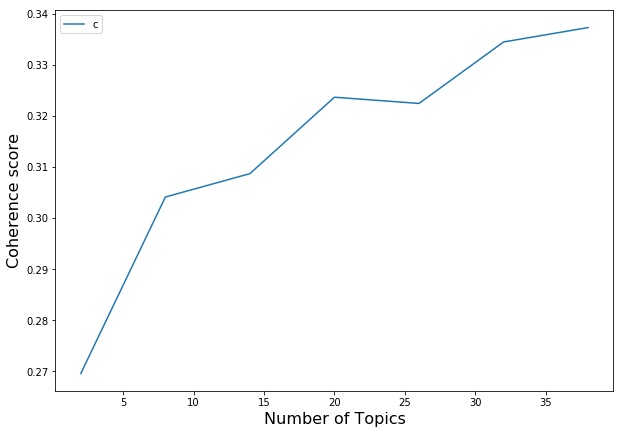

In [25]:
limit=40; start=2; step=6;
x = range(start, limit, step)

plt.figure(figsize=(10, 7))
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics", fontsize=16)
plt.ylabel("Coherence score", fontsize=16)
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2696
Num Topics = 8  has Coherence Value of 0.3041
Num Topics = 14  has Coherence Value of 0.3087
Num Topics = 20  has Coherence Value of 0.3236
Num Topics = 26  has Coherence Value of 0.3224
Num Topics = 32  has Coherence Value of 0.3344
Num Topics = 38  has Coherence Value of 0.3373


From the graph, we observe an intial peak at 20, before the dip and then the rise again. We will choose the point with the initial rise as our optimal number of topics.  

In [28]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.050*"month" + 0.029*"percent" + 0.029*"respondent" + 0.027*"survey" + '
  '0.026*"increase" + 0.025*"manufacturer" + 0.024*"business" + 0.022*"level" '
  '+ 0.020*"inventory" + 0.018*"expect"'),
 (1,
  '0.081*"percent" + 0.043*"report" + 0.034*"sale" + 0.032*"year" + '
  '0.031*"increase" + 0.019*"construction" + 0.018*"loan" + 0.017*"commercial" '
  '+ 0.013*"period" + 0.013*"plan"'),
 (2,
  '0.039*"report" + 0.020*"demand" + 0.018*"increase" + 0.018*"retail" + '
  '0.015*"sale" + 0.014*"price" + 0.014*"service" + 0.013*"recent_week" + '
  '0.013*"commercial" + 0.012*"rise"'),
 (3,
  '0.043*"loan" + 0.033*"bank" + 0.029*"rate" + 0.020*"demand" + '
  '0.018*"mortgage" + 0.018*"decline" + 0.017*"large" + 0.014*"continue" + '
  '0.013*"sale" + 0.013*"credit"'),
 (4,
  '0.052*"sale" + 0.050*"strong" + 0.040*"report" + 0.038*"remain" + '
  '0.038*"continue" + 0.024*"early" + 0.020*"retailer" + 0.018*"slow" + '
  '0.017*"year" + 0.017*"high"'),
 (5,
  '0.048*"price" + 0.032*"incre

## Finding the dominant topic in each sentence

In [29]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.3453,"report, growth, continue, increase, firm, note...",var ref = document.referrer; var bBPath = bei...
1,1,15.0,0.4116,"report, growth, continue, increase, firm, note...",var ref = document.referrer; var bBPath = bei...
2,2,15.0,0.3990,"report, growth, continue, increase, firm, note...",var ref = document.referrer; var bBPath = bei...
3,3,15.0,0.3557,"report, growth, continue, increase, firm, note...",var ref = document.referrer; var bBPath = bei...
4,4,15.0,0.3896,"report, growth, continue, increase, firm, note...",var ref = document.referrer; var bBPath = bei...
5,5,15.0,0.4096,"report, growth, continue, increase, firm, note...",var ref = document.referrer; var bBPath = bei...
6,6,15.0,0.4003,"report, growth, continue, increase, firm, note...",var ref = document.referrer; var bBPath = bei...
7,7,15.0,0.4621,"report, growth, continue, increase, firm, note...",var ref = document.referrer; var bBPath = bei...
8,8,15.0,0.4512,"report, growth, continue, increase, firm, note...",var ref = document.referrer; var bBPath = bei...
9,9,15.0,0.4573,"report, growth, continue, increase, firm, note...",var ref = document.referrer; var bBPath = bei...


In [30]:
df_dominant_topic.tail()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
5143,5143,13.0,0.0790,"price, year, loan, expect, month, sale, increa...",var ref = document.referrer; var bBPath = bei...
5144,5144,3.0,0.2050,"loan, bank, rate, demand, mortgage, decline, l...",var ref = document.referrer; var bBPath = bei...
5145,5145,19.0,0.2185,"director, business, feel, rate, inflation, lar...",var ref = document.referrer; var bBPath = bei...
5146,5146,19.0,0.1809,"director, business, feel, rate, inflation, lar...",var ref = document.referrer; var bBPath = bei...
5147,5147,19.0,0.2810,"director, business, feel, rate, inflation, lar...",var ref = document.referrer; var bBPath = bei...


## Find the most representative document for each topic

In [31]:
# Group top 14 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(14)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5738,"month, percent, respondent, survey, increase, ...",var ref = document.referrer; var bBPath = bei...
1,1.0,0.7748,"percent, report, sale, year, increase, constru...",var ref = document.referrer; var bBPath = bei...
2,2.0,0.6486,"report, demand, increase, retail, sale, price,...",var ref = document.referrer; var bBPath = bei...
3,3.0,0.4006,"loan, bank, rate, demand, mortgage, decline, l...",var ref = document.referrer; var bBPath = bei...
4,4.0,0.3734,"sale, strong, report, remain, continue, early,...",var ref = document.referrer; var bBPath = bei...
5,5.0,0.7693,"price, increase, expect, sale, report, remain,...",var ref = document.referrer; var bBPath = bei...
6,6.0,0.6998,"report, year, price, increase, production, rem...",var ref = document.referrer; var bBPath = bei...
7,7.0,0.6360,"demand, price, increase, remain, note, continu...",var ref = document.referrer; var bBPath = bei...
8,8.0,0.5646,"equipment, large, steel, supply, price, percen...",var ref = document.referrer; var bBPath = bei...
9,9.0,0.6222,"sale, year, expect, increase, business, firm, ...",var ref = document.referrer; var bBPath = bei...


## Topic distribution across documents

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(14)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,15.0,"report, growth, continue, increase, firm, note...",335.0,0.0651
1,15.0,"report, growth, continue, increase, firm, note...",262.0,0.0509
2,15.0,"report, growth, continue, increase, firm, note...",241.0,0.0468
3,15.0,"report, growth, continue, increase, firm, note...",273.0,0.0530
4,15.0,"report, growth, continue, increase, firm, note...",122.0,0.0237
5,15.0,"report, growth, continue, increase, firm, note...",150.0,0.0291
6,15.0,"report, growth, continue, increase, firm, note...",153.0,0.0297
7,15.0,"report, growth, continue, increase, firm, note...",263.0,0.0511
8,15.0,"report, growth, continue, increase, firm, note...",270.0,0.0524
9,15.0,"report, growth, continue, increase, firm, note...",214.0,0.0416
